In [235]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

# # for creating a responsive plot
# %matplotlib ipympl
# %matplotlib widget

import torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

## Dataset & Plot Helpers

In [236]:

words = open('names.txt', 'r').read().splitlines()

In [237]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [238]:
import itertools
def plot_heatmap(tensor, text=True, nrow=None, ncol=None, fig_size=(10,10), cmap='Blues', textc='gray'):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= cmap)
    # manually write text on each cell (seaborn annot doesn't look good)
    if text:
        for i, j in itertools.product(range(nrow), range(ncol)):
            # x:col, y:rows, the origin is top left corner, makes bottom <->top
            plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color=textc)
    plt.axis('off')

In [239]:
def plot_2d_emb(emb_lkt, nclass, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
    for i in range(nclass):
        plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
    plt.grid('minor')

# def plot_3d_emb(emb_lkt, nclass, figsize=(8,8)):
#     tensor = emb_lkt.data.detach().numpy()
#     fig = plt.figure(figsize=figsize)
#     ax = Axes3D(fig)
#     ax.scatter(xs= tensor[:,0], ys=tensor[:,1], zs=tensor[:,2], s=200)
#     for i in range(nclass):
#         ax.text(x=tensor[i,0], y=tensor[i,1],z=tensor[i,2], s=i_to_s[i], ha='center', va='center', color='white')
#     # displaying the plot
#     plt.grid('minor')
#     plt.show()

In [240]:
WINDOW_SIZE = 5
NCLASS = 27

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs)
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182625, 5])
Dev: xs.shape = torch.Size([22655, 5])
Ts: xs.shape = torch.Size([22866, 5])
TR_SIZE = 182625
WINDOW_SIZE = 5
NCLASS = 27


# Implementing Backpropagation manually for intuitive understanding

## a simple model with 1 hidden layer

In [241]:
EMB_DIM = 6
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)

# Layer 1 : linear
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) * 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
b1 = torch.randn( 1, HLAYER_SIZE, generator=g) * 0.1 # just for fun

# Layer 2 : Batch Norm
bn_gain = torch.ones(1, HLAYER_SIZE) * 0.1 + 1.0
bn_bias = torch.zeros(1, HLAYER_SIZE) * 0.1
# these are not model params, we update them recursively
# bn_mean_ema = torch.zeros(1, HLAYER_SIZE)
# bn_std_ema = torch.ones(1, HLAYER_SIZE)


# Layer 3 : Linear
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.1
b2 = torch.randn( 1, NCLASS, generator=g) * 0.1

parameters = [emb_lkt, W1, b1, W2, b2, bn_gain , bn_bias]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

18189

## expand the model to store all intermediate values in the Forward pass to compute the gradient w.r.t all

In [242]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5
# momentum for moving average
# the lower the BATCH_SIZE the lower the MOMENTUM!!
MOMENTUM = 0.001

# for i in range(NSTEPS):
    
# Forward path

# cinstruct a mini batch 
mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
Xb = Xtr[mini_batch_idx]
Yb = Ytr[mini_batch_idx]
# transform it to embeddings
batch_emb = emb_lkt[Xb] # BATCH_SIZE, WINDOW_SIZE, emb_dim
batch_emb_cat = batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)

# layer 1 : linear
hprebn = batch_emb_cat@W1 + b1

# layer 2: batch norm

## mean
bn_meani = hprebn.sum(dim=0, keepdim=True) / BATCH_SIZE
## var
bn_diff = hprebn - bn_meani
bn_diff2 = bn_diff**2

# note: Bessel's correction for computing Variance
# dividing by (BATCH_SIZE-1) instead of BATCH_SIZE
bn_vari = bn_diff2.sum(dim=0, keepdim=True) / (BATCH_SIZE-1)
bn_std_inv = (bn_vari + 1e-5)**-0.5

bn_raw = bn_std_inv * bn_diff

hpreact = bn_bias + bn_gain * bn_raw

# # pass the training set through
# bn_mean_ema = (1-MOMENTUM) * bn_mean_ema + MOMENTUM * bn_meani
# bn_std_ema = (1-MOMENTUM) * bn_std_ema + MOMENTUM * bn_stdi

h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE

logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
logits_max = logits.max(dim=1, keepdim=True).values # [BATCH_SIZE, 1]
# subtract max for numerical stability,
# has no effect on qs bc of normalization in counts,
# expect logits_max to have zero gradients as well
norm_logits = logits - logits_max
#[BATCH_SIZE, NCLASS]

counts = norm_logits.exp() # [BATCH_SIZE, NCLASS]
counts_sum = counts.sum(dim=1, keepdim=True) # [BATCH_SIZE, 1]

# for division use **-1 instead of "/", PyTorch backward pass seems to give real numbers for the later
counts_sum_inv = counts_sum**-1 # [BATCH_SIZE, 1]

# q: model prediction distribution
# p: true empirical distribution -> p(correct label) = 1 o.w. p=0
qs = counts * counts_sum_inv # [BATCH_SIZE, NCLASS]
Nlog_qs = -qs.log() # [BATCH_SIZE, NCLASS]
# [BATCH_SIZE, 1]
# Correct class
cc_Nlog_qs = Nlog_qs[torch.arange(BATCH_SIZE), Yb]
# Expected cc_Nlog_qs
loss_mini = cc_Nlog_qs.mean()
# F.cross_entropy(logits, Ytr[mini_batch_idx])

# lossi.append(loss_mini.log10().item())
# stepi.append(i)

# PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [cc_Nlog_qs, Nlog_qs, qs, counts_sum_inv, counts_sum, counts,
          norm_logits, logits_max, logits, h, hpreact, 
          bn_raw, bn_std_inv, bn_vari, bn_diff2, bn_diff,
          bn_meani, hprebn, batch_emb_cat, batch_emb
          ]:
    t.retain_grad()
loss_mini.backward()
loss_mini

tensor(4.1083, grad_fn=<MeanBackward0>)

### utility function we will use later when comparing manual gradients to PyTorch gradients

In [243]:

@torch.no_grad()
def cmp(var_name, d_t, t):
    # check if exactly equal
    ex = torch.all(d_t == t.grad).item()
    # bc of floating point arithmetic we might get a little bit different result
    app = torch.allclose(input=d_t, other=t.grad, atol=1e-5, rtol=1e-8)
    maxdiff = (d_t - t.grad).abs().max().item()
    print(f'{var_name:15s} | exact: {str(ex):5s} | appoximate: {str(app):5s} | maxx diff : {maxdiff}')

## add a prefix "d_" to a variable as the gradient of loss w.r.t that variable

- the shape of the gradient of a variable (Matrix) will be equal to the variable itself. WHY??

- "d_variable" is the gradient of loss w.r.t all the elements of the "variable"

## Duality of Broadcasting or Replication and Vector Sum, Mean, Max, Min
Whenever there's a sum or max or min in the forward pass,
it's backward pass is broadcasting and replication of the output to construct a same shape with the input.

And Vice Versa!!

Whenever there's a  broadcasting or replication in the forward pass,
it's backward pass is the sum or accumulation of the gradient of all created paths.

In [244]:
with torch.no_grad():
    print(cc_Nlog_qs.shape)
    # loss_mini = cc_Nlog_qs.mean()
    # l = (a+b+c) / 3 -> dl/da = 1/3 = dl/db = dl/dc
    d_cc_Nlog_qs = torch.ones(BATCH_SIZE)*1/ BATCH_SIZE
    print(d_cc_Nlog_qs.shape)
    print(d_cc_Nlog_qs)
    cmp('cc_Nlog_qs', d_t=d_cc_Nlog_qs, t=cc_Nlog_qs)

torch.Size([32])
torch.Size([32])
tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312])
cc_Nlog_qs      | exact: True  | appoximate: True  | maxx diff : 0.0


## THe gradient of plucking out elements in forward pass : inserting global elements to a larger zeros in backward

In [245]:
with torch.no_grad():
    print(Nlog_qs.shape)
    # cc_Nlog_qs = Nlog_qs[torch.arange(BATCH_SIZE), Ytr[mini_batch_idx]]
    # d cc_Nlog_qs / d Nlog_qs = p  -> p(correct label) = 1 o.w. p=0
    d_Nlog_qs = torch.zeros_like(Nlog_qs)
    d_Nlog_qs[torch.arange(BATCH_SIZE), Yb] = d_cc_Nlog_qs[torch.arange(BATCH_SIZE)]
    print(d_Nlog_qs.shape)
    # print(d_Nlog_qs)
    cmp('Nlog_qs', d_t=d_Nlog_qs, t=Nlog_qs)

torch.Size([32, 27])
torch.Size([32, 27])
Nlog_qs         | exact: True  | appoximate: True  | maxx diff : 0.0


In [246]:
with torch.no_grad():
	print(qs)
	print(qs.shape)
	# Nlog_qs = -qs.log() # [BATCH_SIZE, NCLASS]
	# d Nlog_qs / d qs = - 1/qs
	d_qs = d_Nlog_qs * -1*qs**-1 
	# the lower probability, q gives to a correct answer,
	# the higher the gradient !
	print(d_qs.shape)
	cmp('qs', d_t=d_qs, t=qs)

tensor([[1.1961e-01, 5.2796e-03, 3.6152e-02, 1.4375e-02, 1.1083e-02, 4.8303e-02,
         1.0305e-01, 1.8258e-02, 1.0576e-02, 1.4575e-02, 1.1316e-01, 8.9372e-03,
         2.2243e-02, 1.6841e-02, 1.2259e-01, 5.5203e-02, 9.9687e-03, 3.2090e-02,
         7.5419e-02, 6.2698e-02, 6.2559e-03, 2.3579e-02, 3.0564e-02, 6.0498e-03,
         1.7254e-02, 3.6951e-03, 1.2187e-02],
        [9.2120e-03, 4.8147e-02, 4.2105e-03, 1.3490e-01, 8.6215e-02, 6.7623e-02,
         7.1044e-03, 5.5442e-02, 1.5558e-02, 1.8761e-02, 1.2430e-02, 4.0137e-03,
         8.7010e-02, 5.8745e-03, 7.7005e-03, 2.0287e-02, 5.6384e-03, 1.3099e-02,
         1.6969e-02, 2.3453e-03, 6.1277e-02, 8.4956e-03, 3.3254e-03, 2.9222e-02,
         1.5519e-02, 7.4873e-02, 1.8475e-01],
        [8.2535e-02, 4.8726e-03, 5.6041e-02, 7.7935e-02, 3.2017e-02, 8.3841e-03,
         6.4006e-02, 2.7730e-02, 1.1258e-02, 7.0999e-03, 5.2047e-03, 8.5091e-03,
         2.5083e-01, 2.1706e-02, 5.4359e-02, 4.6823e-02, 4.9794e-02, 1.3844e-02,
         8.2096e-

In [247]:
with torch.no_grad():
	# qs = counts * counts_sum_inv # [BATCH_SIZE, NCLASS]
	print(counts_sum_inv.shape)
	print(counts.shape)
	'''
	here we 2 operations, 1st broadcasting (replicating) counts_sum_inv,
	2nd Multiplication . we backprop step by step and we know
	that if one element has multiple path to the loss, with like replication,
	we accumulate the gradients of all paths:
	l = a[3,3] * b[3,1] = a[3,3] * rep(dim=1, b[3,1] | b[3,1] | b[3,1] )
	= a11*b1    a12*b1      a13*b1
	a21*b2    a22*b2      a23*b2
	a31*b3    a32*b3      a33*b3

	d l / d rep_b = a
	d l / d b = (d l / d rep_b).sum(dim=1, keep column)
	d l / d b1 = a11+a12+a13
	'''
	d_counts_sum_inv = (d_qs * counts).sum(dim=1, keepdim=True) # [BATCH_SIZE, 1]
	print(d_counts_sum_inv.shape)
	cmp('counts_sum_inv', d_t=d_counts_sum_inv, t=counts_sum_inv)


	# [BATCH_SIZE, NCLASS] : [BATCH_SIZE, NCLASS] * [BATCH_SIZE, 1]
	# Broadcasting for backward pass for counts
	d_counts = d_qs * counts_sum_inv
	# but we will have another accumilating gradient for counts
	# coming from counts_sum_inv

torch.Size([32, 1])
torch.Size([32, 27])
torch.Size([32, 1])
counts_sum_inv  | exact: True  | appoximate: True  | maxx diff : 0.0


In [248]:
with torch.no_grad():
	# counts_sum_inv = 1/counts_sum # [BATCH_SIZE, 1]
	print(counts_sum.shape)
	# d counts_sum_inv / d counts_sum = -1* counts_sum ** -2
	d_counts_sum = d_counts_sum_inv * -counts_sum**-2 # [BATCH_SIZE, 1]
	print(d_counts_sum.shape)
	cmp('counts_sum', d_t=d_counts_sum, t=counts_sum)

torch.Size([32, 1])
torch.Size([32, 1])
counts_sum      | exact: True  | appoximate: True  | maxx diff : 0.0


In [249]:
with torch.no_grad():
	# counts_sum = counts.sum(dim=1, keepdim=True) # [BATCH_SIZE, 1]
	print(counts.shape) # [BATCH_SIZE, NCLASS]
	print(counts_sum.shape) # [BATCH_SIZE, 1]
	# d counts_sum / d counts = 1 for each element
	# broadcast to other path
	d_counts = d_counts + d_counts_sum * 1.0
	# dqs / d counts = counts_sum_inv + counts* (d counts_sum_inv / d counts)
	# dqs / d counts = counts_sum_inv + counts*(counts_sum**-2)

	print(d_counts.shape)
	cmp('counts', d_t=d_counts, t=counts)

torch.Size([32, 27])
torch.Size([32, 1])
torch.Size([32, 27])
counts          | exact: True  | appoximate: True  | maxx diff : 0.0


## Duality of Broadcasting or Replication and Vector Sum, Mean, Max, Min
Whenever there's a sum or max or min in the forward pass,
it's backward pass is broadcasting and replication of the output to construct a same shape with the input.

And Vice Versa!!

Whenever there's a  broadcasting or replication in the forward pass,
it's backward pass is the sum or accumulation of the gradient of all created paths.

In [250]:
with torch.no_grad():
	# counts = norm_logits.exp() # [BATCH_SIZE, NCLASS]
	print(norm_logits.shape) # [BATCH_SIZE, NCLASS]
	print(counts.shape) # [BATCH_SIZE, NCLASS]
	# d counts / d norm_logits = counts
	d_norm_logits = d_counts * counts

	print(d_norm_logits.shape)
	cmp('norm_logits', d_t=d_norm_logits, t=norm_logits)

torch.Size([32, 27])
torch.Size([32, 27])
torch.Size([32, 27])
norm_logits     | exact: True  | appoximate: True  | maxx diff : 0.0


In [251]:
with torch.no_grad():
	# norm_logits = logits - logits_max # [BATCH_SIZE, NCLASS]
	print(logits_max.shape) # [BATCH_SIZE, 1]
	print(logits.shape) # [BATCH_SIZE, NCLASS]
	print(d_norm_logits.shape)
	'''
	here we 2 operations, 1st broadcasting (replicating) counts_sum_inv,
	2nd subtraction . we backprop step by step and we know
	that if one element has multiple path to the loss, with like replication,
	we accumulate the gradients of all paths:
	l = a[3,3] - b[3,1] = a[3,3] - rep(dim=1, b[3,1] | b[3,1] | b[3,1] )
	= a11-b1    a12-b1      a13-b1
	a21-b2    a22-b2      a23-b2
	a31-b3    a32-b3      a33-b3

	d l / d rep_b = a
	d l / d b = (d l / d rep_b).sum(dim=1, keep column)
	d l / d b1 = a11+a12+a13

	d norm_logits / d rep_logits_max = -1
	d rep_logits_max / d logits_max = sum(dim=1, (d norm_logits / d rep_logits_max) )
	'''
	d_logits_max = (d_norm_logits * -1).sum(dim=1, keepdim=True)

	print(d_logits_max.shape)
	cmp('d_logits_max', d_t=d_logits_max, t=logits_max)
	print(d_logits_max)
	# the same gradient for logits, copy with clone for safety
	d_logits = d_norm_logits.clone()
	# but we will have another accumulating gradient for counts
	# coming from counts_sum_inv

torch.Size([32, 1])
torch.Size([32, 27])
torch.Size([32, 27])
torch.Size([32, 1])
d_logits_max    | exact: True  | appoximate: True  | maxx diff : 0.0
tensor([[ 5.1223e-09],
        [ 3.9581e-09],
        [-2.7940e-09],
        [-2.7940e-09],
        [ 4.6566e-09],
        [ 4.1910e-09],
        [-2.3283e-09],
        [ 1.1642e-09],
        [-1.8626e-09],
        [-1.8626e-09],
        [ 0.0000e+00],
        [ 5.5879e-09],
        [ 2.3283e-09],
        [ 9.3132e-10],
        [ 2.5611e-09],
        [ 0.0000e+00],
        [ 6.9849e-10],
        [-1.1642e-09],
        [-2.7940e-09],
        [ 2.7940e-09],
        [ 2.3865e-09],
        [-1.8626e-09],
        [ 0.0000e+00],
        [-1.2806e-09],
        [-1.8626e-09],
        [ 5.5879e-09],
        [-5.5879e-09],
        [ 1.3970e-09],
        [ 3.2596e-09],
        [ 2.5611e-09],
        [ 4.6566e-10],
        [ 1.8626e-09]])


We expected to zero gradients for logits_max bc when we subtract it for numerical stability, it has no effect on qs bc of normalization of counts.

and here it's roughly correct, e-9 bc of your floating point precision

In [252]:
with torch.no_grad():
	# logits_max = logits.max(dim=1, keepdim=True).values # [BATCH_SIZE, 1]
	print(logits.shape) # [BATCH_SIZE, NCLASS]
	print(logits_max.shape) # [BATCH_SIZE, 1]

	'''
	the element with the max logit has effect here and
    get local_gradient=1 . others get gradient=0)
	'''
	# d cc_Nlog_qs / d Nlog_qs = p  -> p(correct label) = 1 o.w. p=0
	temp = torch.zeros_like(logits)
	temp[torch.arange(BATCH_SIZE), torch.argmax(logits, dim=1)] = 1.0
	d_logits = d_logits + d_logits_max * temp

	'''
	Another way of doing the same:
	d_logits += F.one_hot(logits.max(dim=1).indices, num_classes=NCLASS) * d_logits_max
	logits.max(dim=1).indices is argmax of max values
	'''
	print(d_logits.shape)
	cmp('logits', d_t=d_logits, t=logits)

torch.Size([32, 27])
torch.Size([32, 1])
torch.Size([32, 27])
logits          | exact: True  | appoximate: True  | maxx diff : 0.0


In [253]:
with torch.no_grad():
	# logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
	print(f'{d_logits.shape=}')
	print(f'{h.shape=}')
	print(f'{W2.shape=}')
	# we have broadcating for b2, replicating rows or  samples
	print(f'{b2.shape=}')
	'''
	In the forward pass, we do the Matrix multiplication,
	to get the output of each sample (row) at each neuron(col)

	but in the backward pass we calculate the gradient
	w.r.t each element and we want the gradient matrix
	to have the same shape as value matrix.
	so pay attention to the meaning of the rows and col
	in the value matrix.
	An element can be:
		1.	in X : "one feature of a sample",
			shape each samples (each row), each features(each col)
			we know that "one feature of a sample" has
			multiple path to the loss via multiple neurons.
			so we need to accumulate the gradients for it.
			
			d loss / d X = global_gradient @ W_transpose

		2.	in W: "one weight of a neuron",
			shape: each feature's weights (each row), each neuron (each col)
			we know that "one weight of a neuron" has
			multiple path to the loss via multiple samples
			in the batch. so we need to accumulate the gradients for it.
			
			d loss / d W = X_transpose @ global_gradient

	Two pieces of information you need to write it in a correct order and shape:
	1.	Forward pass is a Matrix Multiplication (Linear Transformation),
	The backward pass is also a Matrix Multiplication (Linear Transformation)
	of global gradient and the other guy.
	
	2. in the backward pass we calculate the gradient
	w.r.t each element so we want the gradient matrix
	to have the same shape as value matrix.
	transpose the other guy and find the correct order
	'''
	d_h = d_logits @ W2.T # BATCH_SIZE , HLAYER_SIZE
	d_W2 = h.T @ d_logits # HLAYER_SIZE , NCLASS
	d_b2 = d_logits.sum(dim=0, keepdim=True)
	print(d_h.shape)
	cmp('h', d_t=d_h, t=h)
	print(d_W2.shape)
	cmp('W2', d_t=d_W2, t=W2)
	print(d_b2.shape)
	cmp('b2', d_t=d_b2, t=b2)



d_logits.shape=torch.Size([32, 27])
h.shape=torch.Size([32, 300])
W2.shape=torch.Size([300, 27])
b2.shape=torch.Size([1, 27])
torch.Size([32, 300])
h               | exact: True  | appoximate: True  | maxx diff : 0.0
torch.Size([300, 27])
W2              | exact: True  | appoximate: True  | maxx diff : 0.0
torch.Size([1, 27])
b2              | exact: True  | appoximate: True  | maxx diff : 0.0


In [254]:
with torch.no_grad():
	# h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
	d_hpreact = (1.0 - h**2) * d_h
	print(d_hpreact.shape)
	cmp('hpreact', d_t=d_hpreact, t=hpreact)

torch.Size([32, 300])
hpreact         | exact: False | appoximate: True  | maxx diff : 9.313225746154785e-10


## BatchNorm Backprob

In [255]:
with torch.no_grad():
    # hpreact = bn_bias + bn_gain * bn_raw
	print(f'{hpreact.shape=}')
	print(f'{bn_bias.shape=}')
	print(f'{bn_gain.shape=}')
	# we have broadcating for b2, replicating rows or  samples
	print(f'{bn_raw.shape=}')
	d_bn_bias = d_hpreact.sum(dim=0, keepdim=True)
	'''
	here it's point-wise multiplication, it's like a scalar
	'''
	d_bn_gain = (d_hpreact * bn_raw).sum(dim=0, keepdim=True)
	d_bn_raw = d_hpreact * bn_gain
	print(d_bn_bias.shape)
	cmp('bn_bias', d_t=d_bn_bias, t=bn_bias)
	print(d_bn_gain.shape)
	cmp('bn_gain', d_t=d_bn_gain, t=bn_gain)
	print(d_bn_raw.shape)
	cmp('bn_raw', d_t=d_bn_raw, t=bn_raw)
	

	

hpreact.shape=torch.Size([32, 300])
bn_bias.shape=torch.Size([1, 300])
bn_gain.shape=torch.Size([1, 300])
bn_raw.shape=torch.Size([32, 300])
torch.Size([1, 300])
bn_bias         | exact: False | appoximate: True  | maxx diff : 7.450580596923828e-09
torch.Size([1, 300])
bn_gain         | exact: False | appoximate: True  | maxx diff : 2.7939677238464355e-09
torch.Size([32, 300])
bn_raw          | exact: False | appoximate: True  | maxx diff : 1.3969838619232178e-09


In [256]:
with torch.no_grad():
	# bn_raw = bn_std_inv * bn_diff
	print(f'{d_bn_raw.shape=}')
	print(f'{bn_std_inv.shape=}')
	print(f'{bn_diff.shape=}')
	
	d_bn_std_inv = (d_bn_raw * bn_diff).sum(dim=0, keepdim=True)
	print(d_bn_std_inv.shape)
	cmp('bn_std_inv', d_t=d_bn_std_inv, t=bn_std_inv)

	# we are not done with bn_diff
	d_bn_diff = d_bn_raw * bn_std_inv

d_bn_raw.shape=torch.Size([32, 300])
bn_std_inv.shape=torch.Size([1, 300])
bn_diff.shape=torch.Size([32, 300])
torch.Size([1, 300])
bn_std_inv      | exact: False | appoximate: True  | maxx diff : 3.725290298461914e-09


In [257]:
with torch.no_grad():
    # bn_std_inv = (bn_vari + 1e-5)**-0.5
	print(f'{d_bn_std_inv.shape=}')
	print(f'{bn_vari.shape=}')
	d_bn_vari = d_bn_std_inv * -0.5*(bn_vari + 1e-5)**-1.5
	print(d_bn_vari.shape)
	cmp('bn_vari', d_t=d_bn_vari, t=bn_vari)

d_bn_std_inv.shape=torch.Size([1, 300])
bn_vari.shape=torch.Size([1, 300])
torch.Size([1, 300])
bn_vari         | exact: False | appoximate: True  | maxx diff : 1.1059455573558807e-09


## Bessel's correction: biased and unbiased Variance

1. Biased VAR:

	- divide the expected value of zero-meaned squares by (batch_size), to get the biased variance

	- if your batch-size is small you underestimate the variance

2. Unbiased VAR:

	- devide the expected value of zero-meaned squares by (batch_size - 1), or multiply the biased Var with (batch_size)/ (batch_size-1) to get the unbiased VAR 

	- to get a better estimate of the var when your batch_size is small (a kind of compensation, by deviding by a lower number)

In BatchNorm paper, they used biased Variance of the batch during training and backward pass, but during inference for updating Variance EMA in running buffer, they used unbiased Variance of the batch!

This actually introduced a trian-test mismatch, and some people like Andrej consider it as a bug!!

In [258]:
with torch.no_grad():
	# bn_vari = bn_diff2.sum(dim=0, keepdim=True) / (BATCH_SIZE-1)
	print(f'{bn_diff2.shape=}')
	print(f'{d_bn_vari.shape=}')
	temp = torch.ones_like(bn_diff2)
	d_bn_diff2 = temp*d_bn_vari / (BATCH_SIZE-1) 
	print(d_bn_diff2.shape)
	cmp('bn_diff2', d_t=d_bn_diff2, t=bn_diff2)

bn_diff2.shape=torch.Size([32, 300])
d_bn_vari.shape=torch.Size([1, 300])
torch.Size([32, 300])
bn_diff2        | exact: False | appoximate: True  | maxx diff : 3.637978807091713e-11


In [259]:
with torch.no_grad():
	# bn_diff2 = bn_diff**2
	print(f'{bn_diff.shape=}')
	d_bn_diff += d_bn_diff2 * 2 * bn_diff
	print(d_bn_diff.shape)
	cmp('bn_diff', d_t=d_bn_diff, t=bn_diff)

bn_diff.shape=torch.Size([32, 300])
torch.Size([32, 300])
bn_diff         | exact: False | appoximate: True  | maxx diff : 1.3969838619232178e-09


In [260]:
with torch.no_grad():
	# bn_diff = hprebn - bn_meani
	print(f'{bn_diff.shape=}')
	print(f'{hprebn.shape=}')
	print(f'{bn_meani.shape=}')
	# Broadcasting forward pass -> vector sum backward pass
	d_bn_meani = -d_bn_diff.sum(dim=0, keepdim=True)
	print(d_bn_meani.shape)
	cmp('bn_meani', d_t=d_bn_meani, t=bn_meani)

	d_hprebn = d_bn_diff.clone()

bn_diff.shape=torch.Size([32, 300])
hprebn.shape=torch.Size([32, 300])
bn_meani.shape=torch.Size([1, 300])
torch.Size([1, 300])
bn_meani        | exact: False | appoximate: True  | maxx diff : 7.450580596923828e-09


In [261]:
with torch.no_grad():
	# bn_meani = hprebn.sum(dim=0, keepdim=True) / BATCH_SIZE
	print(f'{bn_meani.shape=}')
	print(f'{hprebn.shape=}')
	# vector sum forward -> Broadcasting backward
	d_hprebn = d_hprebn + d_bn_meani/BATCH_SIZE
	print(d_bn_meani.shape)
	cmp('hprebn', d_t=d_hprebn, t=hprebn)

bn_meani.shape=torch.Size([1, 300])
hprebn.shape=torch.Size([32, 300])
torch.Size([1, 300])
hprebn          | exact: False | appoximate: True  | maxx diff : 1.3969838619232178e-09


In [262]:
with torch.no_grad():
	# hprebn = batch_emb_cat@W1 + b1
	print(f'{hprebn.shape=}')
	print(f'{batch_emb_cat.shape=}')
	print(f'{W1.shape=}')
	# we have broadcating for b2, replicating rows or  samples
	print(f'{b1.shape=}')
	
	d_batch_emb_cat = d_hprebn @ W1.T # BATCH_SIZE , Window*emb
	d_W1 = batch_emb_cat.T @ d_hprebn # window*emb , HLAYER_SIZE
	# broadcast in forward -> vector sum in backward
	d_b1 = d_hprebn.sum(dim=0, keepdim=True)
	print(d_batch_emb_cat.shape)
	cmp('batch_emb_cat', d_t=d_batch_emb_cat, t=batch_emb_cat)
	print(d_W1.shape)
	cmp('W1', d_t=d_W1, t=W1)
	print(d_b1.shape)
	cmp('b1', d_t=d_b1, t=b1)

hprebn.shape=torch.Size([32, 300])
batch_emb_cat.shape=torch.Size([32, 30])
W1.shape=torch.Size([30, 300])
b1.shape=torch.Size([1, 300])
torch.Size([32, 30])
batch_emb_cat   | exact: False | appoximate: True  | maxx diff : 3.725290298461914e-09
torch.Size([30, 300])
W1              | exact: False | appoximate: True  | maxx diff : 8.381903171539307e-09
torch.Size([1, 300])
b1              | exact: False | appoximate: True  | maxx diff : 6.752088665962219e-09


we expected to see a zero gradient for b1:

In [263]:
d_b1

tensor([[ 4.6566e-10, -1.3970e-09,  1.8626e-09,  6.1118e-10, -1.4552e-09,
          6.9849e-10,  6.9849e-10,  1.1642e-10, -9.3132e-10,  4.6566e-10,
         -4.0745e-10,  2.3283e-10,  5.8208e-10, -2.3283e-10, -3.7253e-09,
          2.3283e-10,  2.3283e-10,  4.1910e-09,  0.0000e+00,  2.3283e-10,
          9.3132e-10, -1.8626e-09,  1.6298e-09,  2.7940e-09, -1.3970e-09,
          0.0000e+00, -9.3132e-10,  2.3283e-10,  0.0000e+00,  0.0000e+00,
         -4.6566e-10,  4.6566e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -6.9849e-10, -4.6566e-10,  0.0000e+00,  2.3283e-10,  2.3283e-10,
         -5.8208e-10, -4.6566e-10,  9.3132e-10, -4.0745e-10,  0.0000e+00,
          9.3132e-10,  1.8626e-09,  9.3132e-10,  3.4925e-10, -1.7462e-10,
          1.8626e-09, -9.3132e-10, -2.3283e-10, -9.3132e-10, -8.1491e-10,
         -3.4925e-10,  1.3970e-09,  0.0000e+00,  2.3283e-10,  2.3283e-10,
          1.1642e-09, -1.1642e-10, -4.6566e-10,  2.3283e-10,  3.4925e-10,
         -1.7462e-10, -6.9849e-10,  9.

In [264]:
with torch.no_grad():
	# batch_emb_cat = batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)
	print(f'{batch_emb_cat.shape=}')
	print(f'{batch_emb.shape=}')
	d_batch_emb = d_batch_emb_cat.view(-1, WINDOW_SIZE, EMB_DIM )
	print(d_batch_emb.shape)
	cmp('batch_emb', d_t=d_batch_emb, t=batch_emb)

batch_emb_cat.shape=torch.Size([32, 30])
batch_emb.shape=torch.Size([32, 5, 6])
torch.Size([32, 5, 6])
batch_emb       | exact: False | appoximate: True  | maxx diff : 3.725290298461914e-09


## Embedding gradient computing

In [265]:
emb_lkt

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
        [-1.5471,  0.6049,  0.0791,  0.9046, -0.4713,  0.7868],
        [-0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261],
        [ 0.6772, -0.8404,  0.9849, -0.1484, -1.4795,  0.4483],
        [-0.0707,  2.4968,  2.4448, -0.6701, -1.2199,  0.3031],
        [-1.0725,  0.7276,  0.0511,  1.3095, -0.8022, -0.8504],
        [-1.8068,  1.2523, -1.2256,  1.2165, -0.9648, -0.2321],
        [-0.3476,  0.3324, -1.3263,  1.1224,  0.5964,  0.4585],
        [ 0.0540, -1.7400,  0.1156,  0.8032,  0.5411, -1.1646],
        [ 0.1476, -1.0006,  0.3801,  0.4733, -0.9103, -0.7830],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830],
        [ 1.7457,  2.1346, -0.8561,  0.5408,  0.6169,  1.5160],
        [-1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928],
        [-0.6279,  0.0770, -1.1641,  1.2473, -0.2706, -1.3635],
        [ 1.3066,  0.3231,  1.0358, -0.8625, -1.2575,  0.9418],
        [-1.3257,  0.1467,  0.1691, -1.5

In [266]:
Xb

tensor([[ 0,  0,  0,  0,  0],
        [ 0, 26,  5, 12, 12],
        [ 0,  9, 19, 19,  9],
        [ 0,  0,  0, 11,  5],
        [13,  1, 21, 18,  9],
        [ 0,  0,  0, 10,  1],
        [ 0,  0,  0,  0, 19],
        [ 1, 19,  8,  1, 14],
        [ 0,  7, 12,  5, 14],
        [ 0,  0,  0,  3,  8],
        [ 5,  3,  8, 21, 11],
        [ 0,  0,  0,  7,  1],
        [ 0,  0, 20,  5,  7],
        [ 0,  0,  0,  0,  5],
        [22,  1, 21,  7,  8],
        [ 0,  0, 11,  1, 25],
        [ 0,  4, 15, 13, 15],
        [20,  1, 13, 15, 18],
        [ 0,  0,  0, 10,  5],
        [ 0,  0,  0,  0, 13],
        [26,  5, 14,  1, 19],
        [ 0,  0,  0, 20,  1],
        [ 0,  0, 20,  1, 13],
        [23,  6, 15, 18,  4],
        [14,  1, 19,  9, 18],
        [ 0,  0,  0,  0,  0],
        [13,  9, 11,  1, 12],
        [ 0,  0,  0,  1,  9],
        [ 0,  0,  0,  0,  1],
        [ 0, 10, 21, 19, 20],
        [ 0,  0,  1,  2, 18],
        [ 0,  0,  0, 10,  1]])

In [267]:
batch_emb

tensor([[[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296]],

        [[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 0.9737,  0.3003, -0.2897, -0.3157,  0.8691,  0.0778],
         [-1.0725,  0.7276,  0.0511,  1.3095, -0.8022, -0.8504],
         [-1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928],
         [-1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928]],

        [[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296],
         [ 0.1476, -1.0006,  0.3801,  0.4733, -0.9103, -0.7830],
         [-0.7093, -0.2928, -2.1803,  0.0793,  0.9019,  1.2028],
         [-0.7093, -0.2928, -2.1803,  0.0793,  0.9019,  1.2028],
         [ 0.1476, -1.0006,  0.3801,  0.4733, -0.9103, -0.7830]],

        [[ 1.5674, 

In [268]:
with torch.no_grad():
	# batch_emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
	print(f'{batch_emb.shape=}')
	print(f'{emb_lkt.shape=}')
	print(f'{Xb.shape=}')
	d_emb_lkt = torch.zeros_like(emb_lkt)
	# the gradient for those characters who were present in the batch
	# accumulate multiple occurrence
	for i,j in itertools.product(range(BATCH_SIZE), range(WINDOW_SIZE)):
		idx = Xb[i,j] # idx: 0-26
		d_emb_lkt[idx] += d_batch_emb[i,j]
	print(d_emb_lkt.shape)
	cmp('emb_lkt', d_t=d_emb_lkt, t=emb_lkt)

batch_emb.shape=torch.Size([32, 5, 6])
emb_lkt.shape=torch.Size([27, 6])
Xb.shape=torch.Size([32, 5])
torch.Size([27, 6])
emb_lkt         | exact: False | appoximate: True  | maxx diff : 2.421438694000244e-08


# shortcut for some intermediate gradient calculations

In [269]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5
# momentum for moving average
# the lower the BATCH_SIZE the lower the MOMENTUM!!
MOMENTUM = 0.001

# for i in range(NSTEPS):
    
# Forward path

# cinstruct a mini batch 
mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
Xb = Xtr[mini_batch_idx]
Yb = Ytr[mini_batch_idx]
# transform it to embeddings
batch_emb = emb_lkt[Xb] # BATCH_SIZE, WINDOW_SIZE, emb_dim
batch_emb_cat = batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)

# layer 1 : linear
hprebn = batch_emb_cat@W1 + b1

# layer 2: batch norm

## mean
bn_meani = hprebn.sum(dim=0, keepdim=True) / BATCH_SIZE
## var
bn_diff = hprebn - bn_meani
bn_diff2 = bn_diff**2

# note: Bessel's correction for computing Variance
# dividing by (BATCH_SIZE-1) instead of BATCH_SIZE
bn_vari = bn_diff2.sum(dim=0, keepdim=True) / (BATCH_SIZE-1)
bn_std_inv = (bn_vari + 1e-5)**-0.5

bn_raw = bn_std_inv * bn_diff

hpreact = bn_bias + bn_gain * bn_raw

# # pass the training set through
# bn_mean_ema = (1-MOMENTUM) * bn_mean_ema + MOMENTUM * bn_meani
# bn_std_ema = (1-MOMENTUM) * bn_std_ema + MOMENTUM * bn_stdi

h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE

logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
logits_max = logits.max(dim=1, keepdim=True).values # [BATCH_SIZE, 1]
# subtract max for numerical stability,
# has no effect on qs bc of normalization in counts,
# expect logits_max to have zero gradients as well
norm_logits = logits - logits_max
#[BATCH_SIZE, NCLASS]

counts = norm_logits.exp() # [BATCH_SIZE, NCLASS]
counts_sum = counts.sum(dim=1, keepdim=True) # [BATCH_SIZE, 1]

# for division use **-1 instead of "/", PyTorch backward pass seems to give real numbers for the later
counts_sum_inv = counts_sum**-1 # [BATCH_SIZE, 1]

# q: model prediction distribution
# p: true empirical distribution -> p(correct label) = 1/BATCH_SIZE o.w. p=0
qs = counts * counts_sum_inv # [BATCH_SIZE, NCLASS]
Nlog_qs = -qs.log() # [BATCH_SIZE, NCLASS]
# [BATCH_SIZE, 1]
cc_Nlog_qs = Nlog_qs[torch.arange(BATCH_SIZE), Yb]
# Expected cc_Nlog_qs
loss_mini = cc_Nlog_qs.mean()
loss_mini_fast = F.cross_entropy(logits, Yb)

# lossi.append(loss_mini.log10().item())
# stepi.append(i)

# PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [cc_Nlog_qs, Nlog_qs, qs, counts_sum_inv, counts_sum, counts,
          norm_logits, logits_max, logits, h, hpreact, 
          bn_raw, bn_std_inv, bn_vari, bn_diff2, bn_diff,
          bn_meani, hprebn, batch_emb_cat, batch_emb
          ]:
    t.retain_grad()
loss_mini.backward()
print(f'loss_mini_fast={loss_mini_fast.item()} , loss_mini={loss_mini.item()}, diff={(loss_mini_fast-loss_mini).item()}')

loss_mini_fast=4.005650520324707 , loss_mini=4.005650043487549, diff=4.76837158203125e-07


## shortcut for Logit gradient
calculating the gradient of loss w.r.t to elements of logit of each sample we can can directly achieve this formula :

d loss / d (k_th dim of logit)  =

	- if the k_th dim is a wrong class prediction:

	= q(k_th dim or class in logit)

	- if the k_th dim is the correct class prediction:

	= q(k_th dim or class in logit) - 1

then backprop the 1st gradient after loss which is unshortcutted: "taking the mean" of NLL

In [270]:
with torch.no_grad():
    print(f'{logits.shape=}')
    '''
    - gradient of plucking out model assigned probability of
    ground truth: inserting the global gradient into zeros
    
    - gradient of NLog_qs : -qs**-1
    
    - gradient of qs, counts,...
    '''
    fastd_logits = F.softmax(logits, dim=1)
    fastd_logits[torch.arange(BATCH_SIZE), Yb] -= 1.0
    

    ''' unshortcutted gradients:
    gradient of batch mean : replication of 1/BATCH_SIZE
    '''
    # mean in the forward pass -> replication in the backward
    # loss_mini = cc_Nlog_qs.mean()
    # l = (a+b+c) / 3 -> dl/da = 1/3 = dl/db = dl/dc
    fastd_logits /= BATCH_SIZE

    print(fastd_logits.shape)
    # print(fastd_logits)
    cmp('new_logits', d_t=fastd_logits, t=logits)

logits.shape=torch.Size([32, 27])
torch.Size([32, 27])
new_logits      | exact: False | appoximate: True  | maxx diff : 6.51925802230835e-09


looking at the formula, we can see that if we sum the logit gradients elements (for all classes), we get:

"sum(qs) - 1 = 0.0"

each row (logit gradients of a sample) has only one Negative element which is for the ground truth label! and all others are Positive.

This has an intuitive meaning:

- Since we update the parameters in the opposite sign of the gradient, it means we are pulling up the logit of the ground truth by a large update to make it 1, and at the same time, pulling down all the wrong classes to make them 0 (proportional to the prediction q(of that element), so if you give high likelihood to a wrong class, the gradient of the logit on that class for the input will be equal to the likelihood to make it zero! and it will happen if the learning rate is 1.0 !

- if we have a correct prediction: q(ground truth) = 1 , then based on the formula, we 0 logit gradient for every element or class. make sense!

tensor([-5.1223e-09, -2.4447e-09, -2.5611e-09, -1.3970e-09, -2.7940e-09,
         9.3132e-10,  1.1642e-09, -1.8626e-09, -1.8626e-09, -9.3132e-10,
        -3.7253e-09, -8.7311e-10,  2.7940e-09,  4.6566e-09, -3.7253e-09,
         0.0000e+00, -1.6298e-09,  2.7940e-09,  3.2596e-09,  3.0268e-09,
        -3.7253e-09,  3.4925e-10,  1.1642e-09, -4.6566e-10,  1.1642e-09,
         1.1642e-09,  1.1642e-09,  3.0268e-09, -1.8626e-09,  2.7940e-09,
        -2.7940e-09,  2.5611e-09])


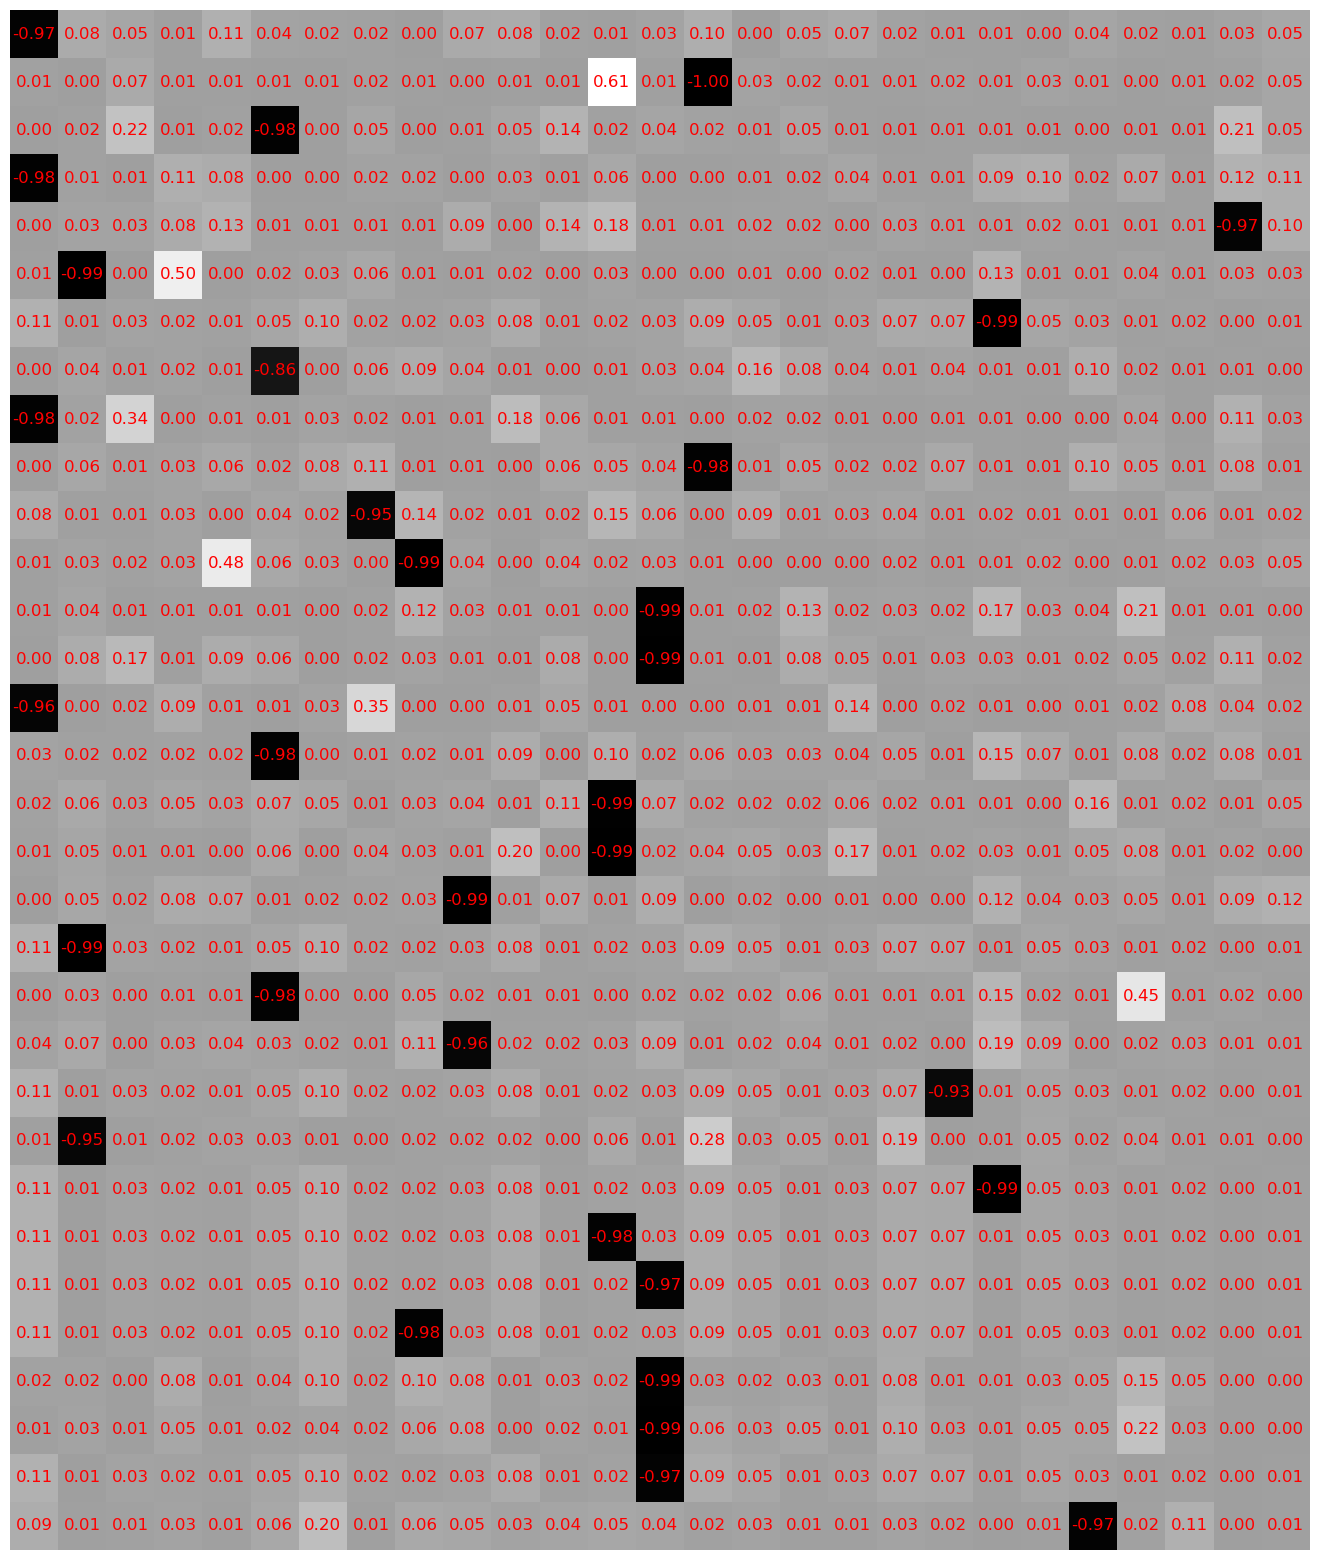

In [271]:
print(fastd_logits.sum(dim=1))
plot_heatmap(fastd_logits*BATCH_SIZE, fig_size=(20,20), cmap='gray', textc='red')
# fastd_logits

## Shortcut for BatchNorm

In [272]:
with torch.no_grad():
	print(f'{hprebn.shape=}')
	print(f'{d_bn_raw.shape=}')
	fastd_hprebn = (1/BATCH_SIZE) * bn_std_inv * ( BATCH_SIZE * d_bn_raw - d_bn_raw.sum(dim=0, keepdim=True) - bn_raw * (BATCH_SIZE/(BATCH_SIZE-1)) * (d_bn_raw*bn_raw).sum(dim=0, keepdim=True) )
	print(fastd_hprebn.shape)
    # print(fastd_logits)
	cmp('new_hprebn', d_t=fastd_hprebn, t=hprebn)

hprebn.shape=torch.Size([32, 300])
d_bn_raw.shape=torch.Size([32, 300])
torch.Size([32, 300])
new_hprebn      | exact: False | appoximate: False | maxx diff : 0.024837380275130272
